# ID Block

Q-Learning

* author: Tim Davey

* email: daveytj206@potsdam.edu

* date: 10/31/2024

* course: CIS 421

* due: 11/13/2024

* assignment: p07-QLearning


# Problem
Implement a Q-learning algorithm in order to teach an agent to navigate an environment, rescue ponies, avoid capture, and escape.

# Imports/Read

I performed tests with two maps. I have included the 2nd map in the repo. Maps can be changed by editing the comments below.

In [ ]:
import random as rand
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

# with open('trolls1.txt', 'r') as file:
with open('trolls5.txt', 'r') as file:
    envr_raw_data = file.readlines()


# Create Globals/Process Board

This section sets various globals for the environment including, the size of the grid, number of ponies, number of trolls and their respective rewards.

Additionally, it sets up variables to be used for board creations and resets.

In [2]:
n_size = -1
num_trolls = -1
num_ponies = -1

escape_location = (-1,-1)
pony_locations = []
obstacle_locations = []
troll_locations = []
used_locations = []
hero_location = (-1,-1)

'''
Directions represent a Moore neighborhood and their relative location
to the center cell
tl = top left
tc = top center
tr = top right
cl = center left
cr = center right
bl = bottom left
bc = bottom center
br = bottom right
'''
directions = {'tl':(-1,-1), 'tc':(-1,0), 'tr':(-1,1),
                       'cl':(0,-1), 'cr':(0, 1), 'bl':( 1,-1), 'bc':(1, 0), 'br':(1, 1)}

#Rewards
# r_values = {'E' :15, 'P': 20, 'T':-15, '—':1}
r_values = {'E' :15, 'P': 10, 'T':-15, '—':2}
# r_values = {'E' :15, 'P': 20, 'T':-15, '—':2}

#N Size
line_0 = envr_raw_data[0].split()
n_size = int(line_0[0])
num_trolls = int(line_0[1])
num_ponies = int(line_0[2])

#Escape Locations
line_1 = envr_raw_data[1].split()
escape_location = (int(line_1[0]), int(line_1[1]))
used_locations.append((int(line_1[0]), int(line_1[1])))

#Pony Locations
line_2 = envr_raw_data[2].split()
for i in range(0,len(line_2), 2):
    pony_locations.append((int(line_2[i]), int(line_2[i+1])))
    used_locations.append((int(line_2[i]), int(line_2[i+1])))

#Obstacle Locations
line_3 = envr_raw_data[3].split()
print(line_3)
if line_3[0] != '-1':
  for i in range(0, len(line_3), 2):
      obstacle_locations.append((int(line_3[i]), int(line_3[i+1])))
      used_locations.append((int(line_3[i]), int(line_3[i+1])))

# Troll Locations
line_4 = envr_raw_data[4].split()
for i in range(0,len(line_4), 2):
    troll_locations.append((int(line_4[i]), int(line_4[i+1])))
    used_locations.append((int(line_4[i]), int(line_4[i+1])))


#Ensure valid hero location
hero_location = (rand.randint(0, n_size-1), rand.randint(0, n_size-1))
while hero_location in used_locations:
    hero_location = (rand.randint(0, n_size-1), rand.randint(0, n_size-1))

## Init board
rows, cols = n_size, n_size
envr = []

print(n_size, num_trolls, num_ponies)
print(f"Escape Location: {escape_location}")
print(f"Pony Locations: {pony_locations}")
print(f"Obstacle Locations: {obstacle_locations}")
print(f"Troll Locations: {troll_locations}")
print(f"Hero Location: {hero_location}")


['-1', '-1']
10 1 6
Escape Location: (8, 3)
Pony Locations: [(4, 2), (4, 4), (5, 5), (6, 5), (8, 5), (3, 6)]
Obstacle Locations: []
Troll Locations: [(1, 7)]
Hero Location: (5, 3)


# Tile Class

This class represents a tile in the environment. This includes empty tiles, ponies, trolls, and the escape. Tiles store both q-values and rewards.

In [3]:
class grid_tile:

  '''
  Constructor

  Creates a grid tile object with a reward and default q-values

  @param pos - position of the tile
  @param tile_type - type of the tile
  @param stepped - true if tile has been stepped on, else false
  @post tile is created
  '''
  def __init__(self, pos, tile_type,stepped=False):
    self.pos = pos
    self.x = pos[0]
    self.y = pos[1]
    self.tile_type = tile_type
    self.reward = 0

    self.tl = self.x - 1, self.y - 1
    self.tc = self.x - 1, self.y
    self.tr = self.x - 1, self.y + 1
    self.cl = self.x, self.y - 1
    self.cr = self.x, self.y + 1
    self.bl = self.x + 1, self.y - 1
    self.bc = self.x + 1, self.y
    self.br = self.x + 1, self.y + 1


    self.q_values = {'tl':0, 'tc':0, 'tr':0, 'cl':0, 'cr':0, 'bl':0, 'bc':0,
                     'br':0}

    self.set_reward(stepped)

  '''
  Tile Type Getter

  Essentially the same as toString, returns the type of the tile i.e 'E', 'P',
  'T', or '—'

  @post tile type is returned
  @return the type of tile

  '''
  def get_tile_type(self):
    return self.tile_type

  '''
  Position Getter

  Returns the position of the tile within the environment

  @post position is returned
  @return the position of the tile
  '''
  def get_pos(self):
    return self.pos

  '''
  Q-Value Reset

  Resets the q-values to default values without checking validity.
  @post q-values are reset
  '''
  def clear_q_values(self):
    self.q_values = {'tl':0, 'tc':0, 'tr':0, 'cl':0, 'cr':0, 'bl':0, 'bc':0, 'br':0}

  '''
  Valid Q-value Check

  Checks whether any move in the Moore Neighborhood is valid and sets the q-value
  accordingly. -1 represents an invalid move.

  @post q-values are checked for validity
  '''
  def set_ivalid_moves(self):
    #Top Left
    if(self.tl[0] < 0 or self.tl[0] >= n_size or self.tl[1] < 0
       or self.tl[1] >= n_size or str(envr[self.tl[0]][self.tl[1]]) == '#'):
      self.q_values['tl'] = -1
    #Top center
    if(self.tc[0] < 0 or self.tc[0] >= n_size or self.tc[1] < 0
       or self.tl[1] >= n_size or str(envr[self.tc[0]][self.tc[1]]) == '#'):
      self.q_values['tc'] = -1
    #Top Right
    if (self.tr[0] < 0 or self.tr[0] >= n_size or self.tr[1] < 0
        or self.tr[1] >= n_size or str(envr[self.tr[0]][self.tr[1]]) == '#'):
      self.q_values['tr'] = -1
    #Center Left
    if (self.cl[0] < 0 or self.cl[0] >= n_size or self.cl[1] < 0
        or self.cl[1] >= n_size or str(envr[self.cl[0]][self.cl[1]]) == '#'):
      self.q_values['cl'] = -1
    #Center Right
    if (self.cr[0] < 0 or self.cr[0] >= n_size or self.cr[1] < 0
        or self.cr[1] >= n_size or str(envr[self.cr[0]][self.cr[1]]) == '#'):
      self.q_values['cr'] = -1
    #Bottom Left
    if (self.bl[0] < 0 or self.bl[0] >= n_size or self.bl[1] < 0
        or self.bl[1] >= n_size or str(envr[self.bl[0]][self.bl[1]]) == '#'):
      self.q_values['bl'] = -1
    #Bottom Center
    if (self.bc[0] < 0 or self.bc[0] >= n_size or self.bc[1] < 0
        or self.bc[1] >= n_size or str(envr[self.bc[0]][self.bc[1]]) == '#'):
      self.q_values['bc'] = -1
    #Bottom Right
    if (self.br[0] < 0 or self.br[0] >= n_size or self.br[1] < 0
        or self.br[1] >= n_size or str(envr[self.br[0]][self.br[1]]) == '#'):
      self.q_values['br'] = -1

  '''
  Q-Value Getter

  Returns the q-values of the tile.

  @post q-values are returned
  @return the q-values of the tile
  '''
  def get_q_values(self):
    return self.q_values

  '''
  Q-Value Setter

  Sets the q-values of the tile.

  @param q_values - the q-values to use for setting
  @post q-values are set
  '''
  def set_q_values(self,q_values):
    self.q_values = q_values

  '''
  Directions Getter

  Returns the directions of the tile.

  @param dir - the direction to return
  @post direction is returned
  '''
  def get_directions(self,dir):
    return directions[dir]

  '''
  Reward Getter

  Returns the reward of the tile.

  @post reward is returned
  @return the reward of the tile
  '''
  def get_reward(self):
    return self.reward

  '''
  Reward Setter

  Sets the reward of the tile. Includes a penatly for re-visiting location.

  @param stepped - true if tile has been stepped on, else false
  @post reward is set based on tile type
  '''
  def set_reward(self,stepped):
    if self.tile_type == 'E':
      self.reward = r_values['E']
    if self.tile_type == 'P':
      self.reward = r_values['P']
    if self.tile_type == 'T':
      self.reward = r_values['T']
    if self.tile_type == '—':
      if stepped:
        self.reward = -0.5
      else:
        self.reward = r_values['—']

  '''
  String Representation

  Returns a string representation of the tile.

  @post string representation is returned
  @return the string representation of the tile
  '''
  def __str__(self):
    return self.tile_type

# Agent Class

This class represents our hero/burglar. It contains variables such as the learning rate, discount factor, and epsilon value.

In [4]:
class agent:
  '''
  Constructor

  Creates an agent object.

  @param pos - position of the agent
  @param name - name of the agent
  @post agent is created
  '''
  def __init__(self, pos, name):
    self.pos = pos
    self.x = pos[0]
    self.y = pos[1]
    self.name = name
    self.q_values = None
    self.learning_rate = 0.5
    self.discount_factor = 0.9
    self.epsilon = 0.3
    self.reward = 0
    self.move = None

  '''
  Position Getter

  Returns the position of the agent.

  @post position is returned
  @return the position of the agent
  '''
  def get_pos(self):
    return self.pos

  '''
  Q-Value Setter

  Sets the q-values of the agent.

  @param q_values - the q-values to use for setting
  @post q-values are set

  '''
  def set_q_values(self, q_values):
    self.q_values = q_values

  '''
  Q-Value Getter

  Returns the q-values of the agent.

  @post q-values are returned
  @return the q-values of the agent
  '''
  def get_q_values(self):
    return self.q_values

  '''
  Probabalistic greedy

  If random value is less than epsilon, random choice is made,
  else best move is chosen. If there is a tie between values, a random choice
  is made again.

  @post move is chosen
  @return the move chosen
  '''
  def find_move(self):
    if rand.random() < self.epsilon:
      move = rand.choices(list(self.q_values.keys()), k=1)
      # self.move = move[0]
      while(self.q_values[move[0]] == -1):
        move = rand.choices(list(self.q_values.keys()), k=1)
      self.move = move[0]
      return move[0]
    else:
      self.move = self.find_best_move()
      return self.move

  '''
  Q Updater

  Updates the q-values of the agent, given the reward.

  @param reward - the reward to use for updating
  @post q-values are updated
  '''
  def q_update(self, reward,new_q_values):
    self.q_values[self.move] = self.q_values[self.move] + self.learning_rate * (reward + (self.discount_factor * max(new_q_values.values())) - self.q_values[self.move])

  '''
  Epsilon Greedy

  Performs greedy search on the q-values of the agent. If there is a tie, a random
  choice is made between the best values.

  @post best move is returned
  '''
  def find_best_move(self):
    max_q_value = max(self.q_values.values())
    max_value_list = []

    for k,v in self.q_values.items():
      if v == max_q_value:
        max_value_list.append((k,v))
    best_move = rand.choice(max_value_list)
    self.move = best_move[0]
    return best_move[0]

  '''
  Position Updater

  Updates agents position local to agent

  @param pos - the new position of the agent
  @post position is updated
  '''
  def move_agent(self, pos):
    self.pos = pos
    self.x = pos[0]
    self.y = pos[1]

  '''
  Learning Rate Setter

  Sets learning rate for agent

  @param learning_rate - the desired learning rate
  @post learning rate is set
  '''
  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  '''
  Discount Factor Setter

  Sets discount factor for agent

  @param discount_factor - the desired discount factor
  @post discount factor is set
  '''
  def set_discount_factor(self, discount_factor):
    self.discount_factor = discount_factor

  '''
  Epsilon Setter

  Sets epsilon for agent

  @param epsilon - the desired epsilon value
  @post epsilon is set
  '''
  def set_epsilon(self, epsilon):
    self.epsilon = epsilon

  def add_reward(self, reward):
    self.reward += reward

  '''
  String Representation

  Returns a string representation of the agent.

  @post string representation is returned
  @return the string representation of the agent
  '''
  def __str__(self):
    return self.name

# Build Board / Board Printer

Note: Board uses 2D array coordinates, not cartesian coordiantes.

In [5]:
#Made outside of other globals as agent class is required, to ease board creation.
hero_object = agent(hero_location, 'B')

'''
Board Creator

Creates a board and places tiles/agent onto the board.
@param hero_object - the agent object
@post board is created
'''
def build_board(envr,hero_object):
  envr.clear()

  # Fill Empty board
  for i in range(rows):
      row = []
      for j in range(cols):
        row.append(grid_tile((i,j), '—'))
      envr.append(row)

  # Set Escape
  envr[escape_location[0]][escape_location[1]] = grid_tile(escape_location, 'E')

  # Set ponies
  for pony in pony_locations:
      envr[pony[0]][pony[1]] = grid_tile(pony, 'P')

  # Set obstacles
  for obstacle in obstacle_locations:
      envr[obstacle[0]][obstacle[1]] = grid_tile(obstacle, '#')

  # Set trolls
  for troll in troll_locations:
      envr[troll[0]][troll[1]] = grid_tile(troll, 'T')

  # Set invalid moves for each cell
  for i in range(rows):
    for j in range(cols):
      if type(envr[i][j]) == grid_tile:
        envr[i][j].set_ivalid_moves()

  #Set hero agent
  hero_location = (rand.randint(0, n_size-1), rand.randint(0, n_size-1))
  while hero_location in used_locations:
      hero_location = (rand.randint(0, n_size-1), rand.randint(0, n_size-1))

  # Get q values for hero starting location
  init_q_values = envr[hero_location[0]][hero_location[1]].get_q_values()

  hero_object = agent(hero_location, 'B')

  #load q values into agent
  envr[hero_location[0]][hero_location[1]] = hero_object
  envr[hero_location[0]][hero_location[1]].set_q_values(init_q_values)

  return hero_object

hero_object = build_board(envr,hero_object)

In [6]:
print(envr[9][9].get_q_values())
print(envr[9][9].cl)
print(envr[9][8])

print(hero_object.get_q_values())


'''
Board Printer

Displays a visual representation of the board.
@post board is printed
'''
def print_board():
    print("# " * (n_size+2))
    for row in envr:
      print("#", end=' ')
      for tile in row:
          print(tile, end=' ')
      print("#", end=' ')
      print()
    print("# " * (n_size+2))

print_board()

{'tl': 0, 'tc': 0, 'tr': -1, 'cl': 0, 'cr': -1, 'bl': -1, 'bc': -1, 'br': -1}
(9, 8)
—
{'tl': 0, 'tc': 0, 'tr': 0, 'cl': 0, 'cr': 0, 'bl': 0, 'bc': 0, 'br': 0}
# # # # # # # # # # # # 
# — — — — — — — — — — # 
# — — — — — — — T — — # 
# — — — — — — B — — — # 
# — — — — — — P — — — # 
# — — P — P — — — — — # 
# — — — — — P — — — — # 
# — — — — — P — — — — # 
# — — — — — — — — — — # 
# — — — E — P — — — — # 
# — — — — — — — — — — # 
# # # # # # # # # # # # 


# Reset Board

This method is used to perform a soft reset on the board.

In [7]:
'''
Board Re-setter

Performs a soft reset on the board, that is it resets locations of
ponies, trolls, obstacles, and escape.

Finds a new random location for the agent.
@param max_move_hit - true if move limit is hit, else false
@param hero_object - the agent object
@post board is reset
'''
def reset_board(max_move_hit,hero_object):
# If max moves have ben reached then agent must be removed from current
#location
  if max_move_hit:
      old_loc = hero_object.get_pos()
      old_q_values = hero_object.get_q_values()
      envr[old_loc[0]][old_loc[1]] = grid_tile(old_loc, '—')
      envr[old_loc[0]][old_loc[1]].set_q_values(old_q_values)

  # Set Escape
  learned_q = envr[escape_location[0]][escape_location[1]].get_q_values()
  envr[escape_location[0]][escape_location[1]] = grid_tile(escape_location, 'E')
  envr[escape_location[0]][escape_location[1]].set_q_values(learned_q)
  # Set Ponies
  for pony in pony_locations:
      learned_q = envr[pony[0]][pony[1]].get_q_values()
      envr[pony[0]][pony[1]] = grid_tile(pony, 'P')
      envr[pony[0]][pony[1]].set_q_values(learned_q)
  # Set Obstacles
  for obstacle in obstacle_locations:
      learned_q = envr[obstacle[0]][obstacle[1]].get_q_values()
      envr[obstacle[0]][obstacle[1]] = grid_tile(obstacle, '#')
      envr[obstacle[0]][obstacle[1]].set_q_values(learned_q)
  # Set Trolls
  for troll in troll_locations:
      learned_q = envr[troll[0]][troll[1]].get_q_values()
      envr[troll[0]][troll[1]] = grid_tile(troll, 'T')
      envr[troll[0]][troll[1]].set_q_values(learned_q)



  # Find new Hero Location
  hero_location = (rand.randint(0, n_size-1), rand.randint(0, n_size-1))
  while hero_location in used_locations:
      hero_location = (rand.randint(0, n_size-1), rand.randint(0, n_size-1))

  #Setup q-values for hero
  init_q_values = envr[hero_location[0]][hero_location[1]].get_q_values()
  envr[hero_location[0]][hero_location[1]] = hero_object
  hero_object = envr[hero_location[0]][hero_location[1]]
  hero_object.move_agent(hero_location)
  envr[hero_location[0]][hero_location[1]].set_q_values(init_q_values)

# Train

In [8]:
'''
Train method

Trains the agent using the q-learning algorithm.

@param epochs - number of epochs to train
@parm learning_rate - the desired learning rate
@param discount_rate - the discount rate
@param epsilon - the epsilon value

'''
def train(epochs, learning_rate, discount_rate, epsilon,hero_object):
  hero_object.set_learning_rate(learning_rate)
  hero_object.set_discount_factor(discount_rate)
  hero_object.set_epsilon(epsilon)
  for i in range(epochs):
    next_tile_type = None
    if i % 2000 == 0:
      print(f"Episode: {i}")
    while(next_tile_type != 'E' and next_tile_type !='T'):
      #Find next move
      move = hero_object.find_move()

      #q_values at current location
      old_q_values = hero_object.get_q_values()

      #Store current position
      old_loc = hero_object.get_pos()

      #Find the Moore neighboord location for updating
      loc_update = directions[move]

      #update location
      new_loc = (old_loc[0] + loc_update[0], old_loc[1] + loc_update[1])

      # find type of next value
      next_tile_type = envr[new_loc[0]][new_loc[1]].get_tile_type()

      # receive reward
      reward = envr[new_loc[0]][new_loc[1]].get_reward()
      hero_object.add_reward(reward)

      #Update q values using next state
      new_q_values = envr[new_loc[0]][new_loc[1]].get_q_values()
      hero_object.q_update(reward,new_q_values)

      #store these q-values to leave behind for tile object
      old_q_values = hero_object.get_q_values().copy()

      #update hero location both on board and locally
      envr[new_loc[0]][new_loc[1]] = hero_object
      hero_object.set_q_values(new_q_values)

      envr[old_loc[0]][old_loc[1]] = grid_tile(old_loc, '—',True)
      envr[old_loc[0]][old_loc[1]].set_q_values(old_q_values)

      hero_object.move_agent(new_loc)

    reset_board(False,hero_object)

train(5000,.5,.5,.1,hero_object)

Episode: 0
Episode: 2000
Episode: 4000


# Test

In [9]:
'''
test method

Performs test runs on the board (e-greedy), based on learned
q-values

@param test_runs - number of test runs to perform
@post test runs are performed
@return list of paths taken, number of ponies found, and number of failures
for each path
'''
def test(test_runs,hero_object):
  path_list = []
  next_tile_type = None
  current_run = 0
  while current_run < test_runs:
      current_path = []

      pony_count = 0
      failure_count = 0
      move_count = 0
      move_count_limit = 300

      #Add current hero location to path
      current_path.append(hero_object.get_pos())

      while next_tile_type != 'E' and next_tile_type !='T' and move_count <= move_count_limit:
        move_count += 1

        #Find next move
        move = hero_object.find_best_move()

        #q_values at current location
        old_q_values = hero_object.get_q_values().copy()

        #Store current position
        old_loc = hero_object.get_pos()

        #Find the Moore neighboord locatin for updating
        loc_update = directions[move]

        #update location
        new_loc = (old_loc[0] + loc_update[0], old_loc[1] + loc_update[1])
        current_path.append(new_loc)

        # find type of next value
        next_tile_type = envr[new_loc[0]][new_loc[1]].get_tile_type()

        # Count Ponies
        if next_tile_type == 'P':
          pony_count += 1

        # receive reward
        reward = envr[new_loc[0]][new_loc[1]].get_reward()
        hero_object.add_reward(reward)

        #grab new q values
        new_q_values = envr[new_loc[0]][new_loc[1]].get_q_values()

        #update hero location both on board and locally
        envr[new_loc[0]][new_loc[1]] = hero_object
        hero_object.set_q_values(new_q_values)

        envr[old_loc[0]][old_loc[1]] = grid_tile(old_loc, '—')
        envr[old_loc[0]][old_loc[1]].set_q_values(old_q_values)

        hero_object.move_agent(new_loc)

      move_limit = False

      if move_count >= move_count_limit:
        move_limit = True
        ## no escape is a failure, no ponies rescued
        pony_count = 0
        failure_count += 1

      reset_board(move_limit,hero_object)
      path_list.append((current_path,pony_count,failure_count))
      current_run += 1
      next_tile_type = None

  return path_list
path_list = test(2,hero_object)

for row in path_list:
  print(row)

([(7, 4), (8, 3)], 0, 0)
([(1, 9), (1, 8), (2, 7), (3, 6), (4, 6), (5, 5), (6, 5), (7, 4), (8, 3)], 3, 0)


# Experiment - helper methods
This section contains print_path and average helper methods for use in experiments

In [10]:
'''
Path Printer

Prints the path of an agent for any particular path. A visited path is set to 0
otherwise the number represents duplicate vists to the tile.

S - Start
F - Finish
# - Number of times cell was visited

Note: Duplicate vists to the start and finish are not shown.

@path - path to print
@post - path is printed
'''
def print_path(path):
  route = path[0]
  ponies = path[1]
  failure = path[2]
  length = len(route)

  path_board = []
  for i in range(rows):
    row = []
    for j in range(cols):
      row.append('-')
    path_board.append(row)

  # Set EScape
  path_board[escape_location[0]][escape_location[1]] = 'E'

  # Set ponies
  for pony in pony_locations:
      path_board[pony[0]][pony[1]] = 'P'

  # Set obstacles
  for obstacle in obstacle_locations:
      path_board[obstacle[0]][obstacle[1]] = '#'

  # Set trolls
  for troll in troll_locations:
      path_board[troll[0]][troll[1]] = 'T'

  for loc in route:
    row = loc[0]
    col = loc[1]

    if isinstance(path_board[row][col], str):
      path_board[row][col] = 0
    else:
      path_board[row][col] += 1

  path_board[route[0][0]][route[0][1]] = 'S'
  path_board[route[-1][0]][route[-1][1]] = 'F'


  print("# " * (n_size+2))
  for i in range(rows):
    print("#", end=' ')
    for j in range(cols):
      print(path_board[i][j], end=' ')
    print("#", end=' ')
    print()
  print("# " * (n_size+2))

  print(f"Length: {length}, Ponies: {ponies}, Failure: {failure}")

print_path(path_list[0])

# # # # # # # # # # # # 
# - - - - - - - - - - # 
# - - - - - - - T - - # 
# - - - - - - - - - - # 
# - - - - - - P - - - # 
# - - P - P - - - - - # 
# - - - - - P - - - - # 
# - - - - - P - - - - # 
# - - - - S - - - - - # 
# - - - F - P - - - - # 
# - - - - - - - - - - # 
# # # # # # # # # # # # 
Length: 2, Ponies: 0, Failure: 0


In [11]:
'''
Average Calucation

Calculates average length of path taken, average ponies found, and average
failures.

@param path_list - list of paths which include #of ponies and # of failures
'''
def average(path_list):
  avg_length = 0
  avg_pony = 0
  avg_failure = 0
  for result in path_list:
  # print(type(result))
    avg_length += len(result[0])
    avg_pony += result[1]
    avg_failure += result[2]

  avg_length /= len(path_list)
  avg_pony /= len(path_list)
  avg_failure /= len(path_list)

  return avg_length,avg_pony,avg_failure

# Experiment

This section is for experimentation to find the best learning and discount rates.

Each experiment displays training progress, as well as a random path taken during testing.

NOTE: See 'Experiment - helper methods' for more information on path trace notation.

Each test consists of 10,000 epochs, followed by 1000 test runs. This was done to get an average of how well the agent learned for any given training.

WARNING: Lots of training and testing, takes some time to run


In [12]:
result_list=[]

'''=========================================================================='''

# rand.seed(6)

epochs = 10000
learning_rate = .1
discount_rate = .5
epsilon = .1
test_count = 1000

hero_object = build_board(envr,hero_object)
# print_board()
train(epochs,learning_rate,discount_rate,epsilon,hero_object)
path_list = test(test_count,hero_object)

#This can be used to see a greater range of paths.
# for i in range(50):
#   print_path(path_list[i])

random_path_num = rand.randint(0,len(path_list)-1)
random_path = path_list[random_path_num]
print(f"Test Run: {random_path_num}")
print_path(random_path)

avg_length,avg_pony,avg_failure= average(path_list)

result_list.append((epochs,learning_rate,discount_rate,epsilon,avg_length,avg_pony,avg_failure))

'''=========================================================================='''
# rand.seed(6)

epochs = 10000
learning_rate = .5
discount_rate = .5
epsilon = .1
test_count = 1000

hero_object = build_board(envr,hero_object)
# print_board()
train(epochs,learning_rate,discount_rate,epsilon,hero_object)
path_list = test(test_count,hero_object)

#This can be used to see a greater range of paths.
# for i in range(50):
#   print_path(path_list[i])

random_path_num = rand.randint(0,len(path_list)-1)
random_path = path_list[random_path_num]
print(f"Test Run: {random_path_num}")
print_path(random_path)

avg_length,avg_pony,avg_failure= average(path_list)

result_list.append((epochs,learning_rate,discount_rate,epsilon,avg_length,avg_pony,avg_failure))
'''=========================================================================='''
# rand.seed(6)

epochs = 10000
learning_rate = .75
discount_rate = .5
epsilon = .1
test_count = 1000

hero_object = build_board(envr,hero_object)
# print_board()
train(epochs,learning_rate,discount_rate,epsilon,hero_object)
path_list = test(test_count,hero_object)

#This can be used to see a greater range of paths.
# for i in range(50):
#   print_path(path_list[i])

random_path_num = rand.randint(0,len(path_list)-1)
random_path = path_list[random_path_num]
print(f"Test Run: {random_path_num}")
print_path(random_path)

avg_length,avg_pony,avg_failure= average(path_list)

result_list.append((epochs,learning_rate,discount_rate,epsilon,avg_length,avg_pony,avg_failure))

'''=========================================================================='''
# rand.seed(6)

epochs = 10000
learning_rate = .9
discount_rate = .5
epsilon = .1
test_count = 1000

hero_object = build_board(envr,hero_object)
# print_board()
train(epochs,learning_rate,discount_rate,epsilon,hero_object)
path_list = test(test_count,hero_object)

#This can be used to see a greater range of paths.
# for i in range(50):
#   print_path(path_list[i])

random_path_num = rand.randint(0,len(path_list)-1)
random_path = path_list[random_path_num]
print(f"Test Run: {random_path_num}")
print_path(random_path)

avg_length,avg_pony,avg_failure= average(path_list)

result_list.append((epochs,learning_rate,discount_rate,epsilon,avg_length,avg_pony,avg_failure))

'''=========================================================================='''
# rand.seed(6)

epochs = 10000
learning_rate = .5
discount_rate = .1
epsilon = .1
test_count = 1000

hero_object = build_board(envr,hero_object)
# print_board()
train(epochs,learning_rate,discount_rate,epsilon,hero_object)
path_list = test(test_count,hero_object)

#This can be used to see a greater range of paths.
# for i in range(50):
#   print_path(path_list[i])

random_path_num = rand.randint(0,len(path_list)-1)
random_path = path_list[random_path_num]
print(f"Test Run: {random_path_num}")
print_path(random_path)

avg_length,avg_pony,avg_failure= average(path_list)

result_list.append((epochs,learning_rate,discount_rate,epsilon,avg_length,avg_pony,avg_failure))

'''=========================================================================='''
# rand.seed(6)

epochs = 10000
learning_rate = .5
discount_rate = .75
epsilon = .1
test_count = 1000

hero_object = build_board(envr,hero_object)
# print_board()
train(epochs,learning_rate,discount_rate,epsilon,hero_object)
path_list = test(test_count,hero_object)

#This can be used to see a greater range of paths.
# for i in range(50):
#   print_path(path_list[i])

random_path_num = rand.randint(0,len(path_list)-1)
random_path = path_list[random_path_num]
print(f"Test Run: {random_path_num}")
print_path(random_path)

avg_length,avg_pony,avg_failure= average(path_list)

result_list.append((epochs,learning_rate,discount_rate,epsilon,avg_length,avg_pony,avg_failure))
'''=========================================================================='''
# rand.seed(6)

epochs = 10000
learning_rate = .5
discount_rate = .9
epsilon = .1
test_count = 1000

hero_object = build_board(envr,hero_object)
# print_board()
train(epochs,learning_rate,discount_rate,epsilon,hero_object)
path_list = test(test_count,hero_object)

#This can be used to see a greater range of paths.
# for i in range(50):
#   print_path(path_list[i])

random_path_num = rand.randint(0,len(path_list)-1)
random_path = path_list[random_path_num]
print(f"Test Run: {random_path_num}")
print_path(random_path)

avg_length,avg_pony,avg_failure= average(path_list)

result_list.append((epochs,learning_rate,discount_rate,epsilon,avg_length,avg_pony,avg_failure))
'''=========================================================================='''
# rand.seed(6)

epochs = 10000
learning_rate = .1
discount_rate = .6
epsilon = .1
test_count = 1000

hero_object = build_board(envr,hero_object)
# print_board()
train(epochs,learning_rate,discount_rate,epsilon,hero_object)
path_list = test(test_count,hero_object)

#This can be used to see a greater range of paths.
# for i in range(50):
#   print_path(path_list[i])

random_path_num = rand.randint(0,len(path_list)-1)
random_path = path_list[random_path_num]
print(f"Test Run: {random_path_num}")
print_path(random_path)

avg_length,avg_pony,avg_failure= average(path_list)

result_list.append((epochs,learning_rate,discount_rate,epsilon,avg_length,avg_pony,avg_failure))


'''=========================================================================='''
# rand.seed(6)

epochs = 10000
learning_rate = .2
discount_rate = .8
epsilon = .1
test_count = 1000

hero_object = build_board(envr,hero_object)
# print_board()
train(epochs,learning_rate,discount_rate,epsilon,hero_object)
path_list = test(test_count,hero_object)

#This can be used to see a greater range of paths.
# for i in range(50):
#   print_path(path_list[i])

random_path_num = rand.randint(0,len(path_list)-1)
random_path = path_list[random_path_num]
print(f"Test Run: {random_path_num}")
print_path(random_path)

avg_length,avg_pony,avg_failure= average(path_list)

result_list.append((epochs,learning_rate,discount_rate,epsilon,avg_length,avg_pony,avg_failure))

'''=========================================================================='''
# rand.seed(6)

epochs = 10000
learning_rate = .2
discount_rate = .7
epsilon = .1
test_count = 1000

hero_object = build_board(envr,hero_object)
# print_board()
train(epochs,learning_rate,discount_rate,epsilon,hero_object)
path_list = test(test_count,hero_object)

#This can be used to see a greater range of paths.
# for i in range(50):
#   print_path(path_list[i])

random_path_num = rand.randint(0,len(path_list)-1)
random_path = path_list[random_path_num]
print(f"Test Run: {random_path_num}")
print_path(random_path)

avg_length,avg_pony,avg_failure= average(path_list)

result_list.append((epochs,learning_rate,discount_rate,epsilon,avg_length,avg_pony,avg_failure))
'''=========================================================================='''
# rand.seed(6)

epochs = 10000
learning_rate = .1
discount_rate = .8
epsilon = .1
test_count = 1000

hero_object = build_board(envr,hero_object)
# print_board()
train(epochs,learning_rate,discount_rate,epsilon,hero_object)
path_list = test(test_count,hero_object)

#This can be used to see a greater range of paths.
# for i in range(50):
#   print_path(path_list[i])

random_path_num = rand.randint(0,len(path_list)-1)
random_path = path_list[random_path_num]
print(f"Test Run: {random_path_num}")
print_path(random_path)

avg_length,avg_pony,avg_failure= average(path_list)

result_list.append((epochs,learning_rate,discount_rate,epsilon,avg_length,avg_pony,avg_failure))


for row in result_list:
  print(row)

Episode: 0
Episode: 2000
Episode: 4000
Episode: 6000
Episode: 8000
Test Run: 655
# # # # # # # # # # # # 
# - - - - - - - - - - # 
# - - - - - - - T - - # 
# - - - - - - - - - - # 
# - - - - - - P - - - # 
# - - P - P - - - - - # 
# - - - - - 0 0 - - - # 
# - - - - - 0 - 0 - - # 
# - - - - 0 - - S - - # 
# - - - F - P - - - - # 
# - - - - - - - - - - # 
# # # # # # # # # # # # 
Length: 7, Ponies: 2, Failure: 0
Episode: 0
Episode: 2000
Episode: 4000
Episode: 6000
Episode: 8000
Test Run: 609
# # # # # # # # # # # # 
# - - - - - - - - - - # 
# - - - - - - - T - - # 
# - - - - - - - - - - # 
# - - - - - - P S - - # 
# - - P - P - - 0 - - # 
# - - - - - 0 0 - - - # 
# - - - - - 0 - - - - # 
# - - - - 0 - - - - - # 
# - - - F - P - - - - # 
# - - - - - - - - - - # 
# # # # # # # # # # # # 
Length: 7, Ponies: 2, Failure: 0
Episode: 0
Episode: 2000
Episode: 4000
Episode: 6000
Episode: 8000
Test Run: 920
# # # # # # # # # # # # 
# - - - - - - - - - - # 
# - - - - - - - T - - # 
# - - - - - - - 

# Graphs

In the following graphs, avg moves, avg ponies collected, and % failures are shown for given learning rates and discount factors.

Note: Each unique color of the bar graph corresponds to a particular set of learning/discount rates for a given set of test runs.

<Figure size 1200x600 with 0 Axes>

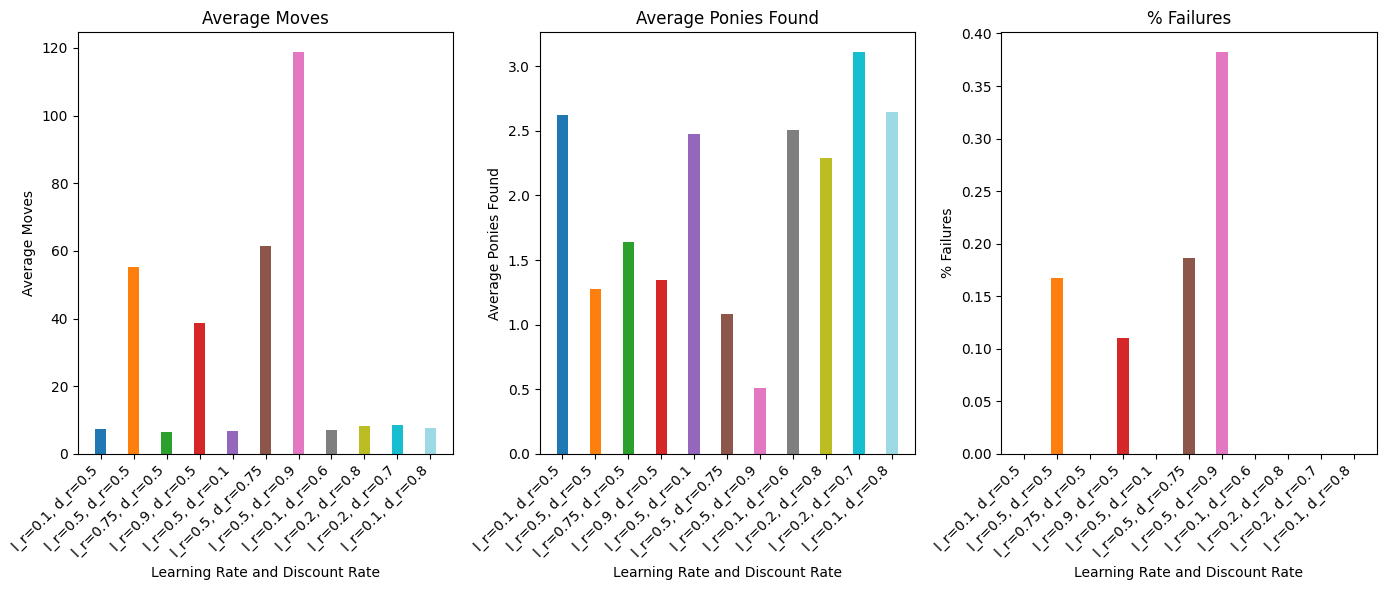

In [13]:
epochs, learning_rate, discount_rate, epsilon, avg_moves, avg_found, avg_failure = zip(*result_list)
plt.figure(figsize=(12, 6))

#colors for bar chart
num_positions = len(result_list)
colors = plt.cm.tab20(np.linspace(0, 1, num_positions))

#Create labels
labels = []
for lr, dr in zip(learning_rate, discount_rate):
    labels.append(f"l_r={lr}, d_r={dr}")



x = np.arange(len(result_list))
bar_width = 0.35

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(14, 6))

#Move Plot
ax1.bar(x, avg_moves, bar_width, label='Avg Moves', color=colors)
ax1.set_xlabel('Learning Rate and Discount Rate')
ax1.set_ylabel('Average Moves')
ax1.set_title('Average Moves')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right')

#Found Plot
ax2.bar(x, avg_found, bar_width, label='Avg Found', color=colors)
ax2.set_xlabel('Learning Rate and Discount Rate')
ax2.set_ylabel('Average Ponies Found')
ax2.set_title('Average Ponies Found')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha='right')

#Failure Plot
ax3.bar(x, avg_failure, bar_width, label='% Failures', color=colors)
ax3.set_xlabel('Learning Rate and Discount Rate')
ax3.set_ylabel('% Failures')
ax3.set_title('% Failures')
ax3.set_xticks(x)
ax3.set_xticklabels(labels, rotation=45, ha='right')


# Display the plot
plt.tight_layout()
plt.show()

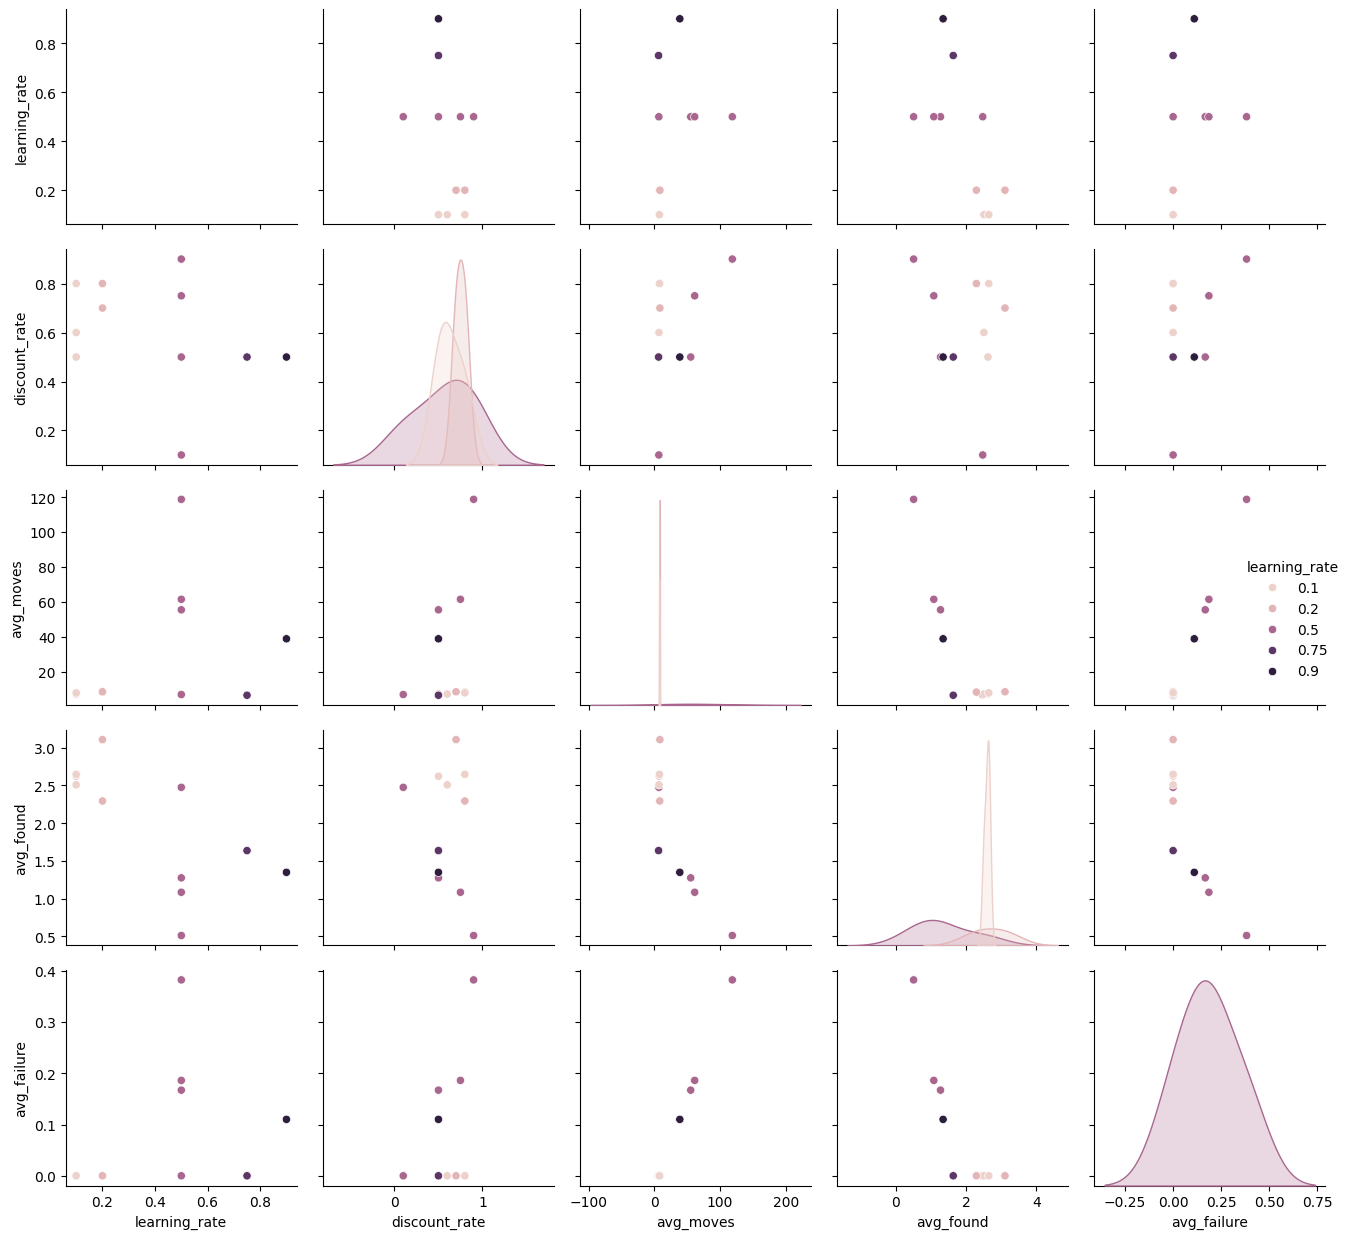

In [14]:
#Create dataframe
df = pd.DataFrame(result_list, columns=['epochs', 'learning_rate', 'discount_rate', 'epsilon', 'avg_moves', 'avg_found','avg_failure'])

# Create plot
sns.pairplot(df, hue='learning_rate', vars=['learning_rate', 'discount_rate', 'avg_moves', 'avg_found','avg_failure'])

# Display the plot
plt.tight_layout()
plt.show()

# Results / Analysis

In my experimentation epochs have been upped to 10000. Rewards have been left mostly as is, however I introduced a penalty (-0.5) if a tile has already been visted. This was to reduce instances where the AI got stuck in testing due to preforming purely greedy search. Epochs were upped to increase convergence. I did test other reward setups, and while some setups did reward more ponies, it often resulted in higher failures and was not universal across learning/discount rates. Hence I have left them as default.

<br>

Increased epochs drastically improved the performance of the agent. As for learning rates and discount rates, it's a bit of a mixed bag. There were often outlier runs that made it difficult to discern which values were truly best, discussion follows:

<br>


Generally, with moderate discount rates (\~0.5), lower learning rates (\~0.1) performed better than moderate or high learning rates. With moderate learning rates (\~0.5), higher discount rates (\~0.75) performed worse. Often times my best results seemed to be with low learning rates with moderate to high discount rates. These can be seen in bars/tests 1,8,9,10,11. Epsilon values have been left at the default (1.0). It seemed that higher epsilon values resulted in worse performance.

<br>

Excluding outlier runs, these observations seem correct. Lower learning rates are less prone to overcorrecting q-values, while higher discount rates prioritize long term rewards, which in turn leads to more ponies collected. Higher epsilon values may have been beneficial, but without temperature/decay they perform worse as the agent learns.   

<br>

Overall, I feel the agent performs well, especially with low learning rates and moderate to high discount rates. While the agent, may not resuce all ponies, very few runs result in failure.

